In [1]:
import os
import sys
sys.path.append("..")

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import distortion_layers as ly

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # ignores warnings

2022-06-23 15:13:02.399150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-23 15:13:02.399187: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Create distortion layer

In [12]:
dcs = {
    1:{
        "contrast": {"factor": [0.2, 0.2]},
        "color": {"factor": [5,0,5]},
        "blur": {"filter_shape": 2, "sigma": 0.},  # kernel size is 'filter_shape * 2 + 1'
        "brightness": {"lower": .7, "upper":1.3}
    },
    2:{
        "contrast": {"factor": [0.2, 2.2]},
        "color": {"factor": [5,0,5]},
        "blur": {"filter_shape": 2, "sigma": 1.},
        "brightness": {"lower": .7, "upper":1.3}
    },
    3:{
        "contrast": {"factor": [0.4, 0.6]},
        "color": {"factor": [20,0,20]},
        "blur": {"filter_shape": 2, "sigma": 5.},
        "brightness": {"lower": .5, "upper":1.5}
    },
    4:{
        "contrast": {"factor": [0.4, 0.6]},
        "color": {"factor": [20,20,20]},
        "blur": {"filter_shape": 4, "sigma": 5.},
        "brightness": {"lower": .5, "upper":1.5}
    }
}


layers = [
    ly.DistortionLayer(layers=[
        ly.RandomColorByChannel(**dcs[i]["color"]), 
        tf.keras.layers.RandomContrast(**dcs[i]["contrast"]),
        ly.RandomBrightness(**dcs[i]["brightness"]),
        ly.RandomGaussianBlur(**dcs[i]["blur"])])
    for i in dcs
]


### Load images

#### Option 1: own data set

In [3]:
train_path = "../data"
tile_size = 128
batch_size = 20

gen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = 0.2
)
flow = gen.flow_from_directory(
    directory=train_path,
    target_size=(tile_size,tile_size),
    color_mode='rgb',  # 'rgb' or 'grayscale' 
    batch_size=batch_size,
    class_mode='binary', # 'sparse' for multiclass, 'binary' for binary 
)


Found 52212 images belonging to 2 classes.


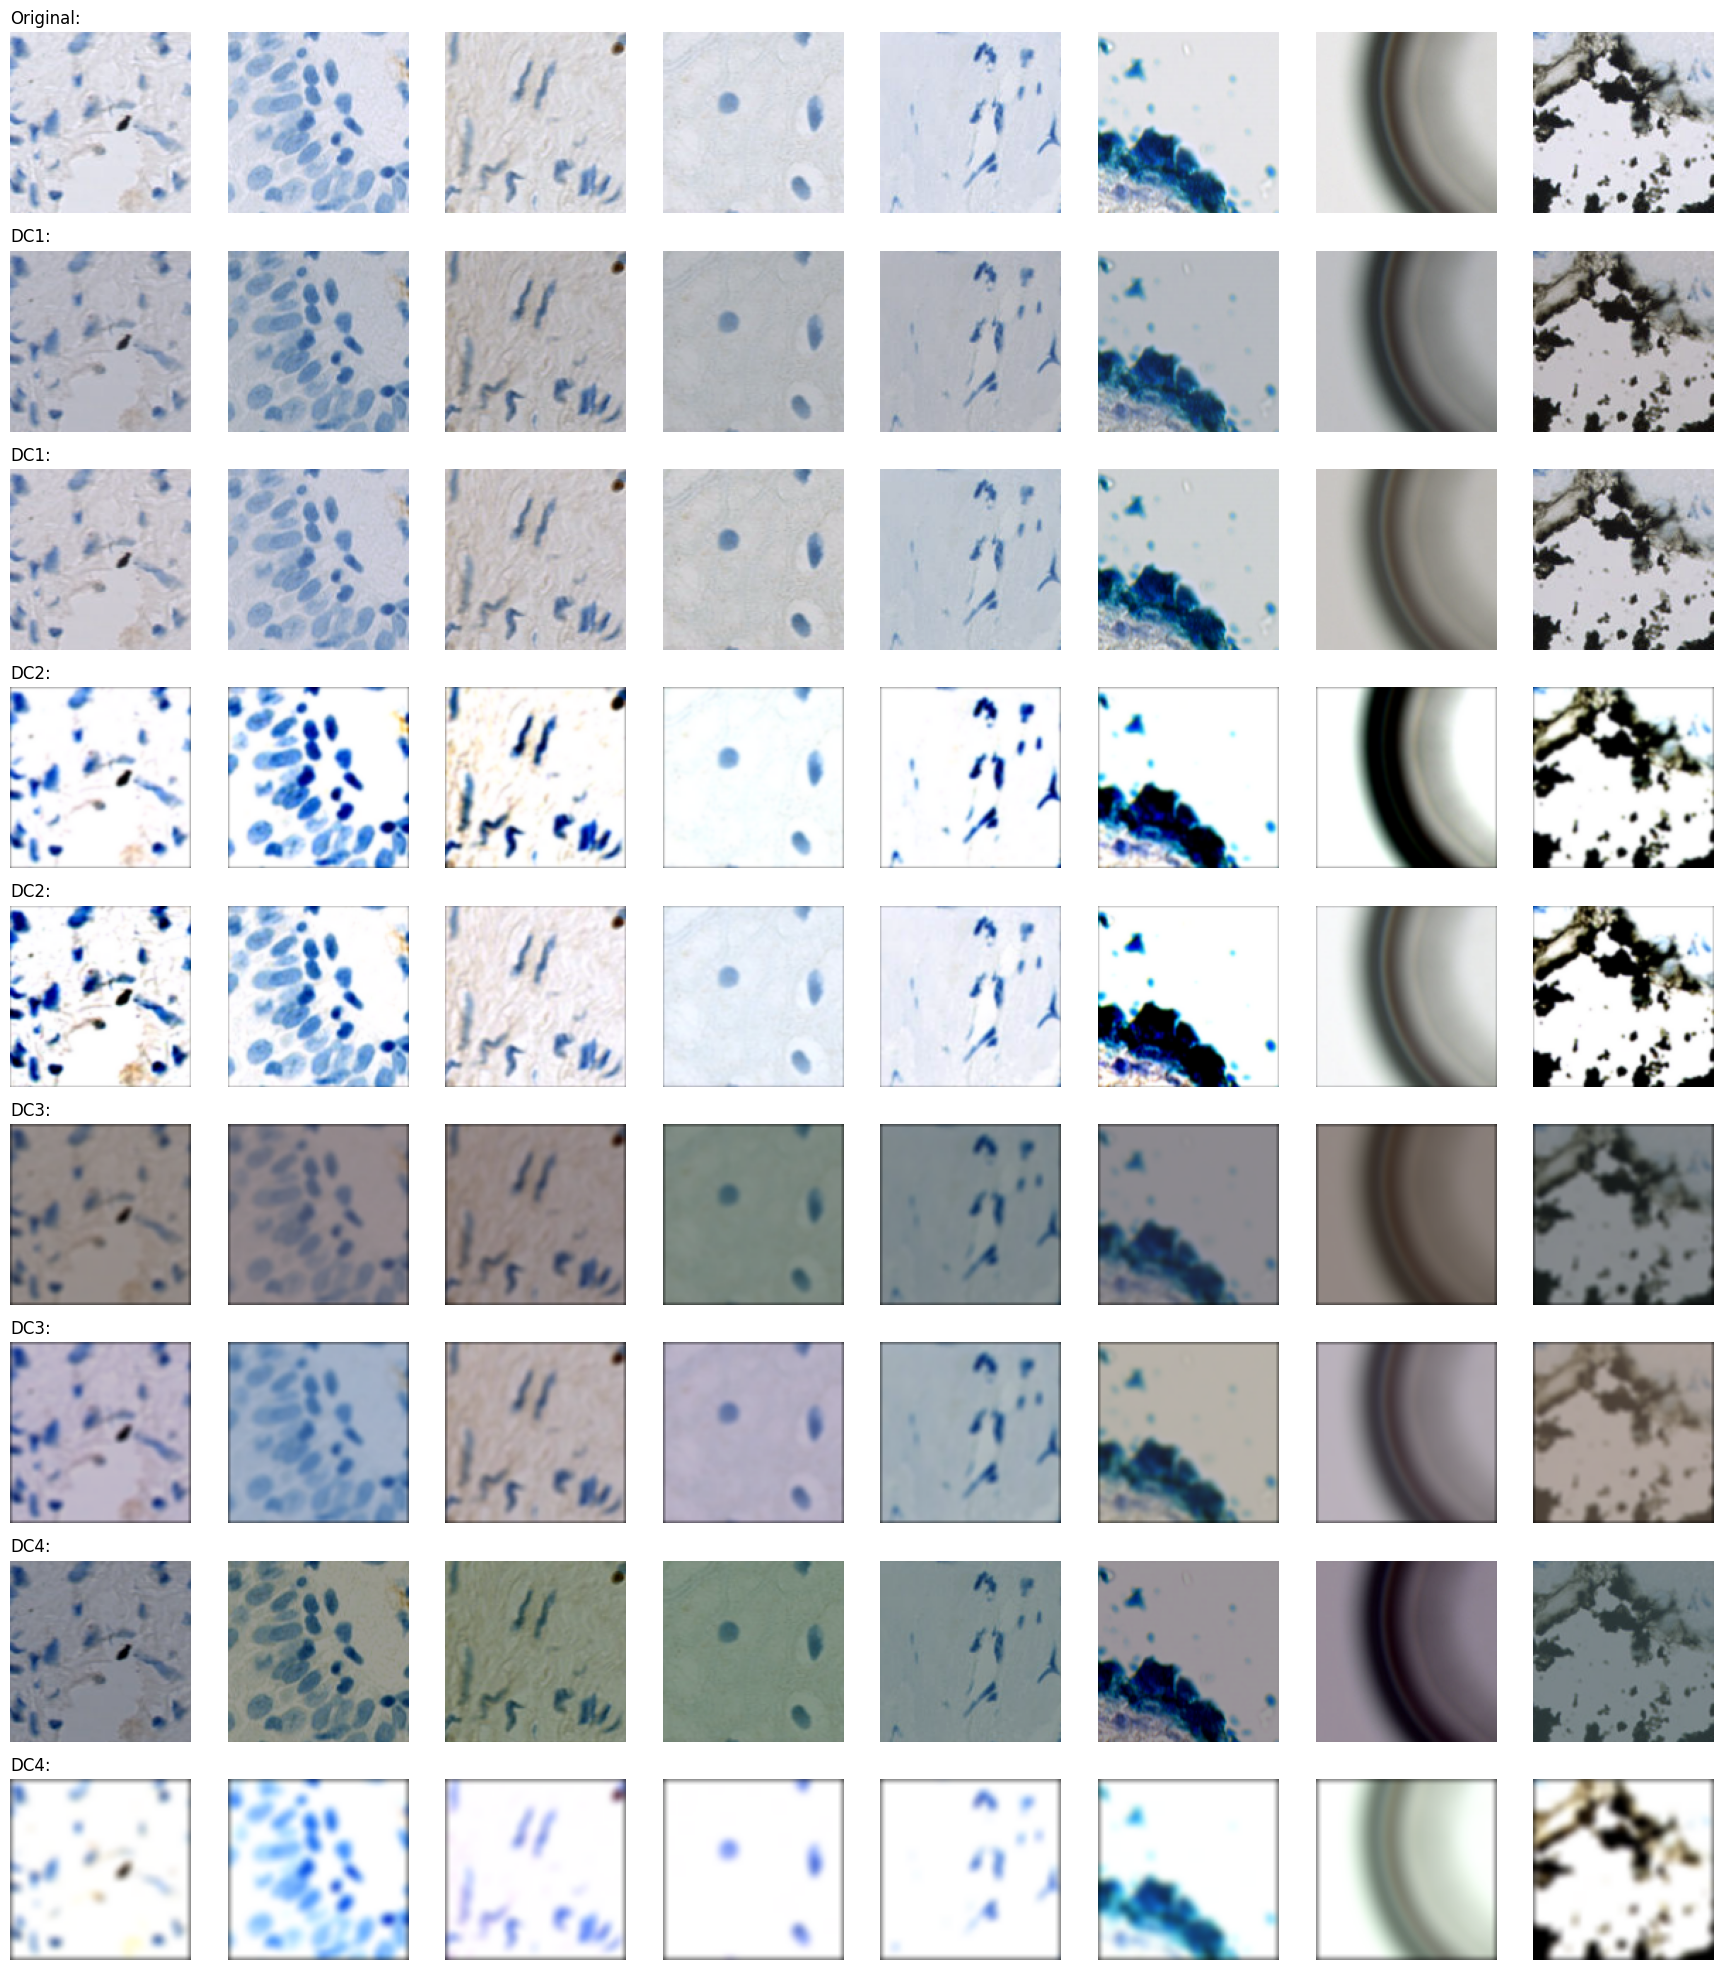

In [14]:
def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    batch = next(iter(flow))
    if type(batch) == tuple:
        images = batch[0][:num_images]
    else:
        images = batch[:num_images]
    # Apply augmentations
    augmented_images = zip(
        images.astype(int),
        layers[0](images).numpy().astype(int),
        layers[0](images).numpy().astype(int),
        layers[1](images).numpy().astype(int),
        layers[1](images).numpy().astype(int),
        layers[2](images).numpy().astype(int),
        layers[2](images).numpy().astype(int),
        layers[3](images).numpy().astype(int),
        layers[3](images).numpy().astype(int),
    )
    row_titles = [
        "Original:",
        "DC1:",
        "DC1:",
        "DC2:",
        "DC2:",
        "DC3:",
        "DC3:",
        "DC4:",
        "DC4:",
    ]
    plt.figure(figsize=(num_images * 2.2, 9 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(9, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=8)

#### Option 2: download dataset from tf downloads